<a href="https://colab.research.google.com/github/nimalan-parameshwaran/CNN_Audio_Classification/blob/main/CNN_Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nimalanparameshwaran","key":"5f166e57e35032998feb58ece8253b81"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.61G/5.61G [01:01<00:00, 123MB/s]
100% 5.61G/5.61G [01:01<00:00, 97.6MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/urbansound8k.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
import cv2
import warnings
warnings.simplefilter("ignore")
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
audio_dataset_path = '/content/data'
df = pd.read_csv('/content/data/UrbanSound8K.csv')

In [ ]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
classes = df['class'].unique()
print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
# of Classes are:  10


In [ ]:
from tqdm import tqdm
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    feature = librosa.feature.mfcc(y=sample,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    final_class_labels = row['class']
    data= features_extract(file_name)
    extracted.append([data,final_class_labels])

8732it [04:59, 29.14it/s]


In [ ]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In [ ]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())

In [ ]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

num_labels = y.shape[1]
model = Sequential()

model.add(Dense(128, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))

model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

In [ ]:
opt = model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=32,epochs=200,validation_data=(x_test, y_test),)

Epoch 1/200
219/219 [==============================] - 4s 9ms/step - loss: 9.1431 - accuracy: 0.1329 - val_loss: 2.1372 - val_accuracy: 0.1906
Epoch 2/200
219/219 [==============================] - 1s 5ms/step - loss: 2.4359 - accuracy: 0.1920 - val_loss: 2.1597 - val_accuracy: 0.1671
Epoch 3/200
219/219 [==============================] - 1s 4ms/step - loss: 2.1514 - accuracy: 0.2361 - val_loss: 2.0857 - val_accuracy: 0.1820
Epoch 4/200
219/219 [==============================] - 1s 5ms/step - loss: 2.0298 - accuracy: 0.2775 - val_loss: 1.9519 - val_accuracy: 0.2456
Epoch 5/200
219/219 [==============================] - 1s 4ms/step - loss: 1.9313 - accuracy: 0.3081 - val_loss: 1.8062 - val_accuracy: 0.3085
Epoch 6/200
219/219 [==============================] - 1s 4ms/step - loss: 1.8357 - accuracy: 0.3502 - val_loss: 1.6750 - val_accuracy: 0.3606
Epoch 7/200
219/219 [==============================] - 1s 4ms/step - loss: 1.7202 - accuracy: 0.3969 - val_loss: 1.5626 - val_accuracy: 0.4465

In [ ]:
predictions = model.predict(x_test)
score = model.evaluate(x_test, y_test)
print(score)

55/55 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.8495
[0.47911784052848816, 0.8494561910629272]


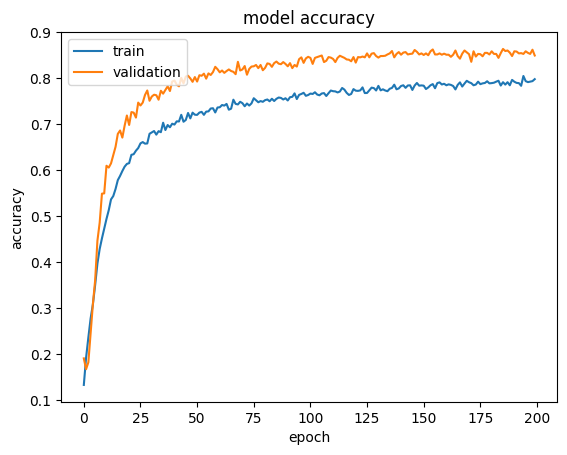

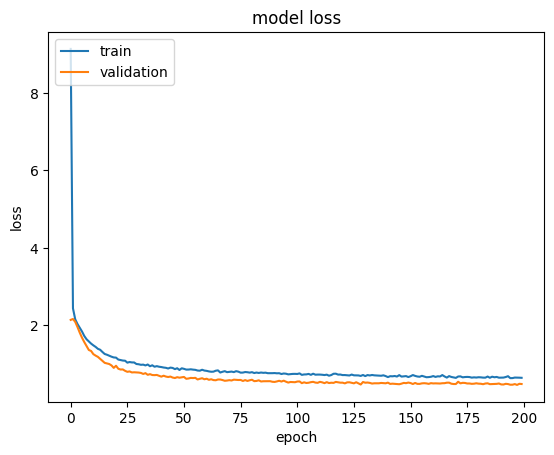

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def extract_feature(file_name):
    audio_date, sample_rate = librosa.load(file_name)
    fea = librosa.feature.mfcc(y=audio_date,sr=sample_rate,n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    return np.array([scaled])

def print_prediction(file_name):
    pred_fea = extract_feature(file_name)
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n')

In [ ]:
test1='/content/data/fold2/100652-3-0-0.wav'
test2="/content/data/fold10/101382-2-0-12.wav"
data1, sampling_rate1 = librosa.load(test1)
data2, sampling_rate2 = librosa.load(test2)

1/1 [==============================] - 0s 29ms/step
The predicted class is: dog_bark 



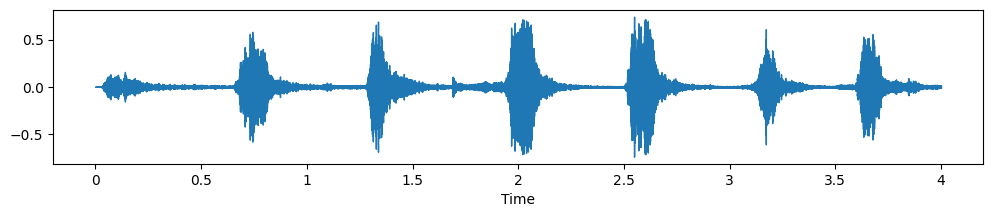

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveshow(data1, sr=sampling_rate1)
ipd.Audio(test1)
print_prediction(test1)
ipd.Audio(test1)

1/1 [==============================] - 0s 47ms/step
The predicted class is: children_playing 



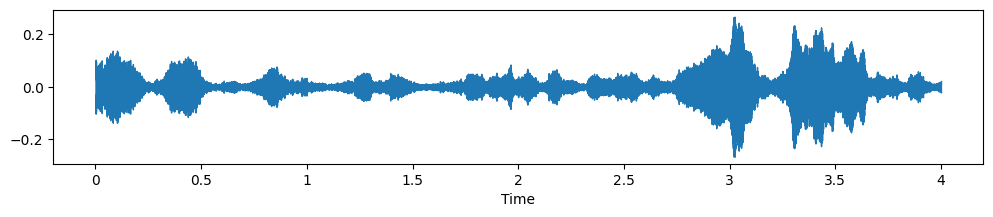

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveshow(data2, sr=sampling_rate2)
ipd.Audio(test2)
print_prediction(test2)
ipd.Audio(test2)

In [ ]:
model.save("modele.h5")
